<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E6-RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 6

## Predict rating using LSTM


In [1]:
!pip install -q optuna
!pip install livelossplot --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


In [44]:
import re
import pandas as pd
import numpy as np

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding, Dropout, LSTM, BatchNormalization, GRU
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adam, Ftrl, Lion
from keras.utils import pad_sequences
import keras.optimizers as opts
from keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras

import optuna
from optuna.samplers import TPESampler

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTraining = dataTraining.drop_duplicates()
dataTraining['plot'] = dataTraining['genres'] + ' ' + dataTraining['title'] + ' ' + dataTraining['plot']
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,"['Short', 'Drama'] Most most is the story of a...","['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,"['Comedy', 'Crime', 'Horror'] How to Be a Seri...","['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"['Drama', 'Film-Noir', 'Thriller'] A Woman's F...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,['Drama'] Executive Suite in a friday afternoo...,['Drama'],7.4
2582,1990,Narrow Margin,"['Action', 'Crime', 'Thriller'] Narrow Margin ...","['Action', 'Crime', 'Thriller']",6.6


In [48]:
dataTraining['rating'].mean()

6.402875601722828

In [49]:
plots = dataTraining['plot']
y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

In [50]:
# plots

In [51]:
# y

In [52]:
longitudes = dataTraining['plot'].apply(len)

# Encontrar la longitud máxima
print(f"Longitud máxima: {longitudes.max()}")
print(f"Longitud promedio: {longitudes.mean()}")

Longitud máxima: 9457
Longitud promedio: 794.8108690144413


# Exercise 6.1

- Remove stopwords
- Lowercase
- split the text in words
- pad_sequences

In [53]:
test_size = 0.2
random_state = 42

# stop_words = set(stopwords.words('english'))
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text.
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

X = plots.apply(tokenize)

tokenizer = Tokenizer() # Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
print('Total words: ', len(tokenizer.word_index))

Total words:  35057


In [54]:
sequences = tokenizer.texts_to_sequences(X)
max_sequence_length = 100 # max(len(x) for x in sequences)
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)
X_padded

array([[    1,  9374,   393, ...,    32,  7859,    95],
       [    0,     0,     0, ...,  1109,   537,  1680],
       [  618,    36,    56, ...,    33,    63,  1857],
       ...,
       [    0,     0,     0, ...,   762,    48,   278],
       [ 6577,     1,  1966, ...,   155,     1,   211],
       [    0,     0,     0, ..., 35057,  3563,  1406]], dtype=int32)

In [55]:
max_sequence_length

100

In [56]:
learning_rate = 0.01
vocab_size = len(tokenizer.word_index) + 1
output_dim = 128

In [57]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_padded, y,
                                                    stratify = y,
                                                    test_size = test_size,
                                                    random_state = random_state)

In [58]:
X_train

array([[    0,     0,     0, ...,     2,  4501,    93],
       [    0,     0,     0, ...,   780,   938,   556],
       [   36,  1223,   520, ...,    27,  6937,   551],
       ...,
       [  148,     6,     9, ...,     5,   847,  1229],
       [    0,     0,     0, ...,  2049,     1,  5137],
       [ 4336,     1, 11324, ...,   264,    59, 10031]], dtype=int32)

In [59]:
X_train.shape

(6315, 100)

In [60]:
vocab_size

35058

# Exercise 6.2

Create a SimpleRNN neural network to predict the rating of a movie

Calculate the testing set accuracy

In [67]:
K.clear_session()
# op = opts.SGD(learning_rate=learning_rate)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length))
model.add(SimpleRNN(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build((None, max_sequence_length))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │       2,243,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,254,081 (8.60 MB)

 Trainable params: 2,254,081 (8.60 MB)

 Non-trainable params: 0 (0.00 B)

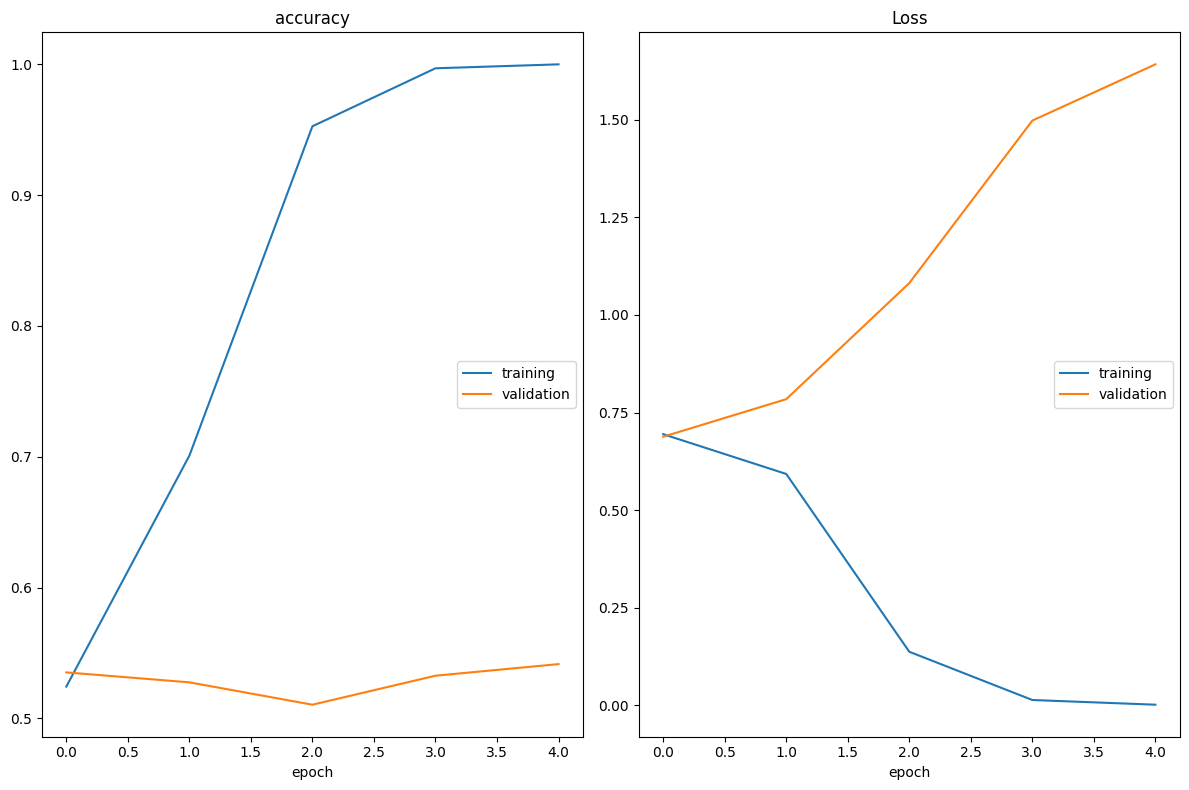

accuracy
	training         	 (min:    0.524, max:    1.000, cur:    1.000)
	validation       	 (min:    0.510, max:    0.541, cur:    0.541)
Loss
	training         	 (min:    0.001, max:    0.694, cur:    0.001)
	validation       	 (min:    0.688, max:    1.643, cur:    1.643)
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.5415 - val_loss: 1.6425


In [68]:
model.fit(X_train, y_train,
          validation_data=[X_test, y_test],
          batch_size=32, epochs=5, verbose=1,
          callbacks=[PlotLossesKeras()])

In [17]:
# def objective(trial):

#     """
#     Function to optimize hyperparameter searching with Optuna for a Neural Network.

#     Args:
#         trial (optuna.Trial): The Optuna trial object for hyperparameter search.

#     Returns:
#         float: The auc score of the trained model.
#     """

#     # Define the search space
#     units1 = trial.suggest_int('units1', 16, 128)
#     activation1 = trial.suggest_categorical('activation1', ['relu', 'tanh', 'sigmoid'])
#     optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'Ftrl', 'Lion'])
#     epochs = trial.suggest_int('epochs', 10, 100)
#     lr = trial.LogUniformDistribution('lr', 1e-4, 1e-1)
#     optimizers = {
#         "Adam": Adam(learning_rate=lr),
#         "RMSprop": RMSprop(learning_rate=lr),
#         "Ftrl": Ftrl(learning_rate=lr),
#         "Lion": Lion(learning_rate=lr),
#     }
#     optimizer = optimizers[optimizer_name]

#     ### Define the model
#     model = Sequential()
#     model.add(Dense(vocab_size, input_dim=max_sequence_length, kernel_regularizer=l2(lr), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     model.add(Dense(units1, activation=activation1))
#     # model.add(Dense(units2, activation=activation2))
#     model.add(Dense(1, activation='sigmoid'))

#     ### Compile the model
#     model.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

#     ### Fit the model
#     model.fit(X_train, y_train,
#               # validation_data=(X_test, y_test),
#               epochs=30,
#               batch_size=32,
#               validation_split=0.1,
#               verbose=True,
#               # callbacks=[EarlyStopping()]#, PlotLossesKeras()]
#               )

#     ### Evaluate the model and return the binary accuracy score
#     _, val_auc = model.evaluate(X_train, y_train)

#     return val_auc

In [18]:
# study_name = "model_simple_neural_network"
# storage_name = "sqlite:///{}.db".format(study_name)

# study_snn = optuna.create_study(study_name=study_name,
#                                 direction="maximize",
#                                 storage=storage_name,
#                                 pruner=optuna.pruners.HyperbandPruner(max_resource="auto"),
#                                 sampler=TPESampler())
# study_snn.optimize(objective, n_trials=10)

# Exercise 6.3

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

In [69]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length))
model.add(LSTM(64))
# model.add(LSTM(32))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.build((None, max_sequence_length))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 64)             │       2,243,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,276,801 (8.69 MB)

 Trainable params: 2,276,801 (8.69 MB)

 Non-trainable params: 0 (0.00 B)

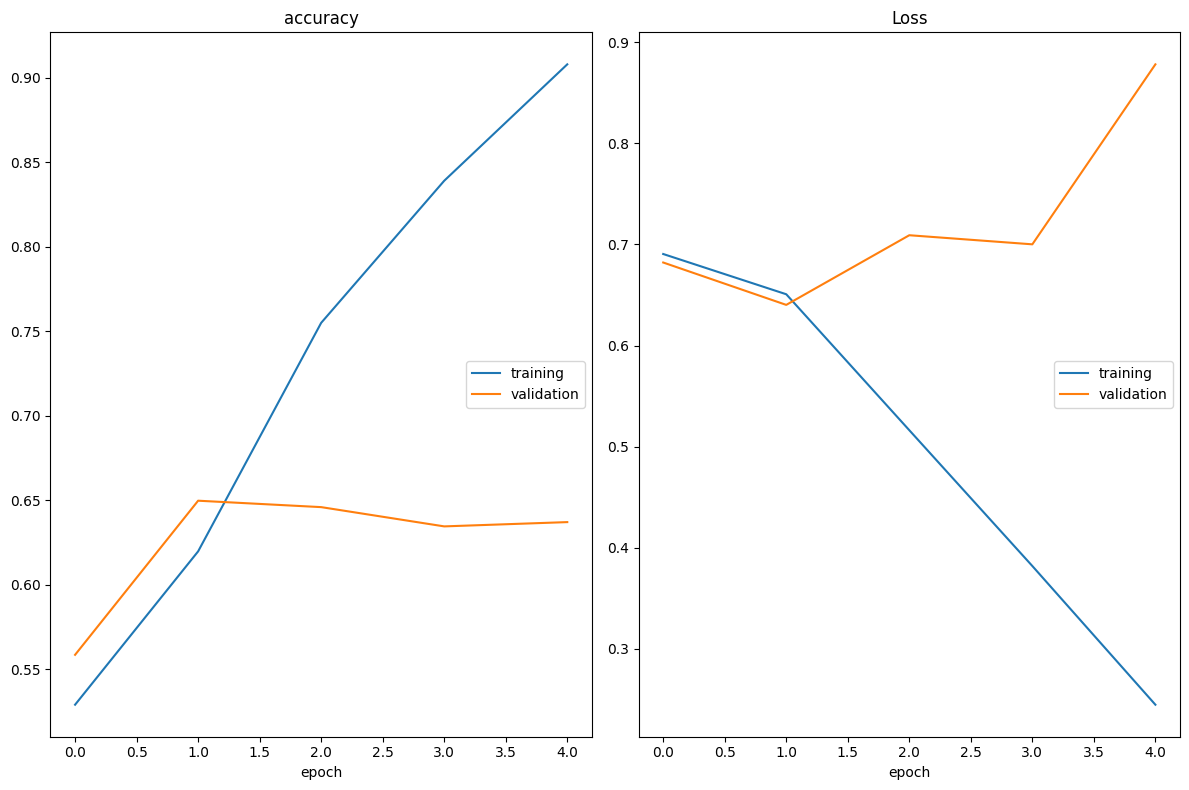

accuracy
	training         	 (min:    0.529, max:    0.908, cur:    0.908)
	validation       	 (min:    0.559, max:    0.650, cur:    0.637)
Loss
	training         	 (min:    0.245, max:    0.691, cur:    0.245)
	validation       	 (min:    0.640, max:    0.878, cur:    0.878)
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9137 - loss: 0.2317 - val_accuracy: 0.6371 - val_loss: 0.8782


In [70]:
model.fit(X_train, y_train,
          validation_data=[X_test, y_test],
          batch_size=32, epochs=5, verbose=1,
          callbacks=[PlotLossesKeras()])

In [71]:
# def objective(trial):

#     """
#     Function to optimize hyperparameter searching with Optuna for a Neural Network.

#     Args:
#         trial (optuna.Trial): The Optuna trial object for hyperparameter search.

#     Returns:
#         float: The auc score of the trained model.
#     """

#     # Define the search space
#     units1 = trial.suggest_int('units1', 16, 128)
#     activation1 = trial.suggest_categorical('activation1', ['relu', 'tanh', 'sigmoid'])
#     optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'Ftrl', 'Lion'])
#     epochs = trial.suggest_int('epochs', 10, 100)
#     lr = trial.LogUniformDistribution('lr', 1e-4, 1e-1)
#     optimizers = {
#         "Adam": Adam(learning_rate=lr),
#         "RMSprop": RMSprop(learning_rate=lr),
#         "Ftrl": Ftrl(learning_rate=lr),
#         "Lion": Lion(learning_rate=lr),
#     }
#     optimizer = optimizers[optimizer_name]

#     ### Define the model
#     model = Sequential()
#     model.add(Dense(vocab_size, input_dim=max_sequence_length, kernel_regularizer=l2(lr), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(LSTM(units1))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))

#     ### Compile the model
#     model.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

#     ### Fit the model
#     model.fit(X_train, y_train,
#               # validation_data=(X_test, y_test),
#               epochs=30,
#               batch_size=32,
#               validation_split=0.1,
#               verbose=True,
#               # callbacks=[EarlyStopping()]#, PlotLossesKeras()]
#               )

#     ### Evaluate the model and return the binary accuracy score
#     _, val_auc = model.evaluate(X_train, y_train)

#     return val_auc

In [ ]:
# study_name = "model_lstm_network"
# storage_name = "sqlite:///{}.db".format(study_name)

# study_snn = optuna.create_study(study_name=study_name,
#                                 direction="maximize",
#                                 storage=storage_name,
#                                 pruner=optuna.pruners.HyperbandPruner(max_resource="auto"),
#                                 sampler=TPESampler())
# study_snn.optimize(objective, n_trials=10)

# Exercise 6.4

Create a GRU neural network to predict the rating of a movie

Calculate the testing set accuracy

In [72]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=64, input_length=max_sequence_length))
model.add(GRU(64))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.build((None, max_sequence_length))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 64)             │       2,243,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,785 (8.66 MB)

 Trainable params: 2,270,785 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

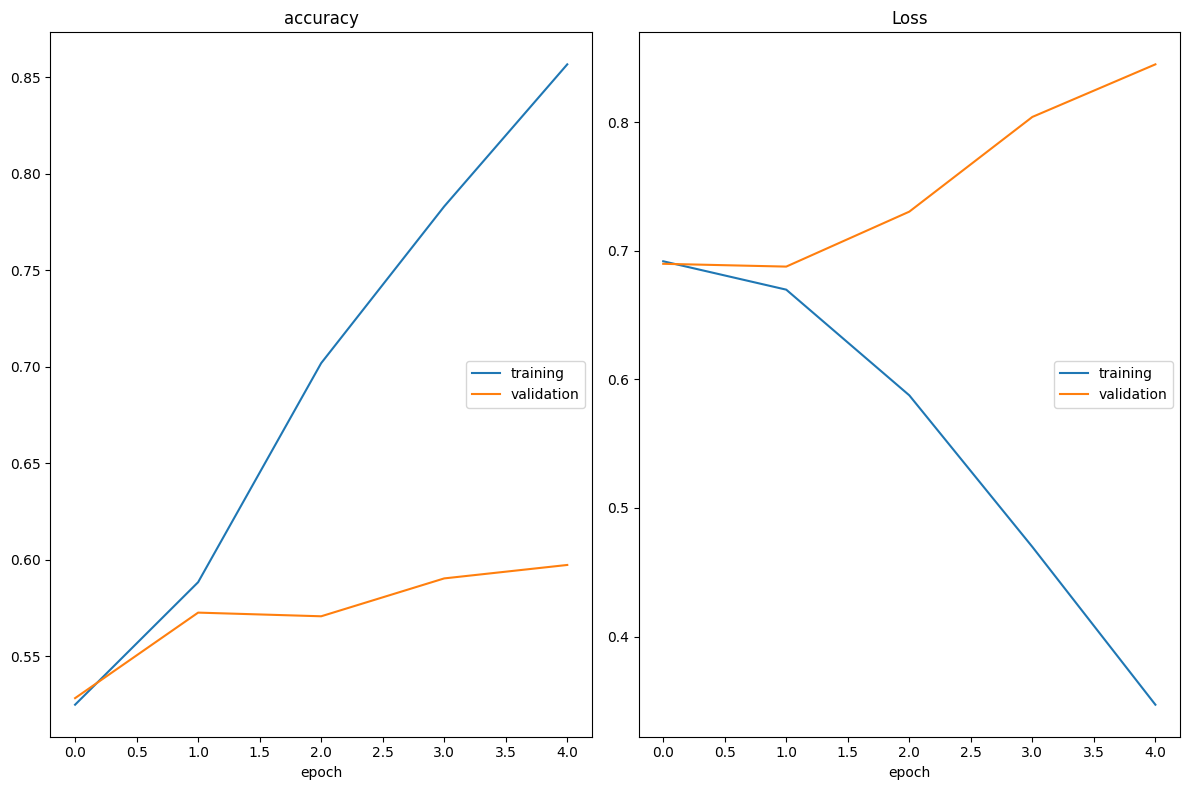

accuracy
	training         	 (min:    0.525, max:    0.857, cur:    0.857)
	validation       	 (min:    0.528, max:    0.597, cur:    0.597)
Loss
	training         	 (min:    0.347, max:    0.692, cur:    0.347)
	validation       	 (min:    0.688, max:    0.845, cur:    0.845)
198/198 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.8632 - loss: 0.3317 - val_accuracy: 0.5972 - val_loss: 0.8450


In [73]:
model.fit(X_train, y_train,
          validation_data=[X_test, y_test],
          batch_size=32, epochs=5, verbose=1,
          callbacks=[PlotLossesKeras()])